In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
%matplotlib inline

In [52]:
from joblib import Parallel, delayed
import joblib

In [162]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [15]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [28]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [33]:
client

Client Scheduler: tcp://10.12.205.14:46552 Dashboard: http://10.12.205.14:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [35]:
members = ['OAAT'+str(i).zfill(4) for i in range(35)]
members.remove('OAAT0003')

In [46]:
def get_tec(member):
    thedir = '/glade/scratch/djk2120/clm5ppe/ens003/histSTEP4/'
    files = sorted(glob.glob(thedir+'*'+member+'*h0*'))
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    tec = np.zeros([40,400])
    for yy in range(40):
        tmp = np.zeros(400)
        for mm in range(12):
            i = mm+yy*12
            file = files[i]
            ds = xr.open_dataset(file)
            tmp = tmp+(days_pm[mm]/365*ds.TOTECOSYSC.values.ravel())
        tec[yy,:]=tmp
    return tec

In [53]:
%%time
with joblib.parallel_backend('dask'):
    out = Parallel(verbose=1)(delayed(get_tec)(member) for member in members)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 36 concurrent workers.


CPU times: user 6.42 s, sys: 910 ms, total: 7.33 s
Wall time: 2min 18s


[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:  2.3min finished


In [10]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens003/hist/'
files = sorted(glob.glob(thedir+'*h0*'))

In [11]:
ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens')

In [13]:
nmonths = len(ds.time)
yr0 = ds['time.year'][0].values
ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [18]:
tec2 = (month_wts(10)/365*ds.TOTECOSYSC).groupby('time.year').sum()

In [54]:
tec = np.zeros([34,40,400])
for i,x in zip(range(34),out):
    tec[i,:,:] = x
da = xr.DataArray(tec,name='TOTECOSYSC',
                  coords=[range(34),range(40),range(400)],
                  dims=['ens','time','gridcell'])
#da.to_netcdf('tec_step4_I2000C285.nc')

In [64]:
tec = xr.open_dataset('tec_step4_I2000C285.nc')['TOTECOSYSC']

In [65]:
t = tec.time
x1 = tec.isel(time=t>29).mean(dim='time').values
x2 = tec2.mean(dim='year').values

In [62]:
la = xr.open_dataset('sparsegrid_landarea.nc').landarea.values

In [28]:
ix.shape

(34, 400)

In [34]:
la_diseq = (ix*la.values).sum(axis=1)
diseq = la_diseq/np.nansum(la)

0.13812428954565417
0.02376242143149783
0.0063775269719879785


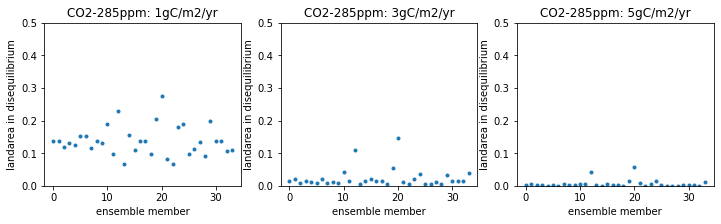

In [70]:
plt.figure(figsize=[12,3])
i=0
for thresh in [1,3,5]:
    i+=1
    ix = abs(x2-x1)>10*thresh
    la_diseq = (ix*la).sum(axis=1)
    diseq = la_diseq/np.nansum(la)
    print(diseq[1:].mean())
    plt.subplot(1,3,i)
    plt.plot(diseq,'.')
    plt.ylim([0,0.5])
    plt.xlabel('ensemble member')
    plt.ylabel('landarea in disequilibrium')
    plt.title('CO2-285ppm: '+str(thresh)+'gC/m2/yr')

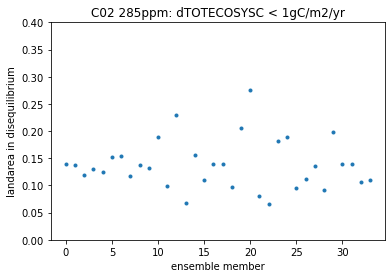

In [38]:
plt.plot(diseq,'.')
plt.ylim([0,0.4])
plt.xlabel('ensemble member')
plt.ylabel('landarea in disequilibrium')
plt.title('C02 285ppm: dTOTECOSYSC < 1gC/m2/yr');

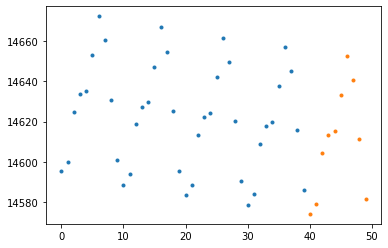

In [20]:
plt.plot(tec.sel(ens=1,gridcell=1).values,'.')
plt.plot(40+np.arange(10),tec2.sel(ens=1,gridcell=1),'.')

In [39]:
thedir = '/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000_step4/run/'
thefile = thedir+'ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000_step4.clm2.h0.0001-01-01-00000.nc'
step4=xr.open_dataset(thefile)

In [47]:
thedir='/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000/run/'
thefile= thedir+'ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000.clm2.h0.2005-02-01-00000.nc'
ds= xr.open_dataset(thefile)
nmonths = len(ds.time)
yr0 = ds['time.year'][0].values
ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [44]:
t = step4['time.year']
x1 = step4.TOTECOSYSC.isel(time=t>31).mean(dim='time')

In [54]:
x2 = (month_wts(10)/365*ds.TOTECOSYSC).groupby('time.year').sum().mean(dim='year')

In [60]:
ix = abs(x2-x1)>10
la_diseq = (ix*la.values)
diseq = la_diseq.sum()/np.nansum(la)
diseq

<xarray.DataArray ()>
array(0.02985583)

In [6]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP3/'
files = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
ds0 = xr.open_mfdataset(files,combine='nested',concat_dim='ens')

In [11]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP4/'
files = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
ds1 = xr.open_mfdataset(files,combine='nested',concat_dim='ens')

In [12]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
files = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
ds2 = xr.open_mfdataset(files,combine='nested',concat_dim='ens')
nmonths = len(ds2.time)
yr0 = ds2['time.year'][0].values
ds2['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [14]:
params =['default','taulnir', 'dleaf', 'tkd_sand', 'bsw_sf', 'n_melt_coef', 'medlynslope', 
         'jmaxb1', 'kmax', 'dbh', 'grperc', 'FUN_fracfixers', 
         'froot_leaf', 'leaf_long', 'tau_cwd', 'k_nitr_max_perday', 'cli_scale', 'vcmaxha']

In [16]:
p2 = []
for p in params:
    if (p=='dleaf'):
        p2.append('dleaf-hi')
    elif (p=='default'):
        p2.append(p)
    else:
        p2.append(p+'-lo')
        p2.append(p+'-hi')

In [138]:
ds = xr.Dataset()
ann_data = np.zeros([34,130,400])
fields = ['TOTVEGC','TOTECOSYSC','TOTSOMC','TOTSOMC_1m']
for field in fields:
    ix = np.arange(80)
    ixt = ds0['time.year']>1
    ann_data[:,ix,:]=ds0[field].isel(time=ixt)
    ix = 80+np.arange(40)
    ixt = ds1['time.year']>1
    ann_data[:,ix,:]=ds1[field].isel(time=ixt)
    ix = 120+np.arange(10)
    mth_wts = month_wts(10)/365
    ann_data[:,ix,:]=(mth_wts*ds2[field]).groupby('time.year').sum().transpose('ens','year','gridcell')

    da = xr.DataArray(ann_data,
                      coords=[('ens',np.arange(34)),
                              ('time',1+np.arange(130)),
                              ('gridcell',np.arange(400))],
                      name=field
                     )
    da.attrs = ds1[field].attrs
    ds[field] = da.copy(deep=True)
ds['keys'] = xr.DataArray(members,dims='ens')

In [48]:
ds

<xarray.Dataset>
Dimensions:     (ens: 34, gridcell: 400, time: 130)
Coordinates:
  * ens         (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * time        (time) int64 1 2 3 4 5 6 7 8 ... 123 124 125 126 127 128 129 130
  * gridcell    (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Data variables:
    TOTVEGC     (ens, time, gridcell) float64 4.514e-05 3.625e-05 ... 0.0 0.0
    TOTECOSYSC  (ens, time, gridcell) float64 4.514e-05 3.625e-05 ... 0.0 0.0
    GPP         (ens, time, gridcell) float64 4.514e-05 3.625e-05 ... 0.0 0.0
    keys        (ens) <U8 'OAAT0000' 'OAAT0001' ... 'OAAT0033' 'OAAT0034'

In [49]:
la = xr.open_dataset('sparsegrid_landarea.nc').landarea

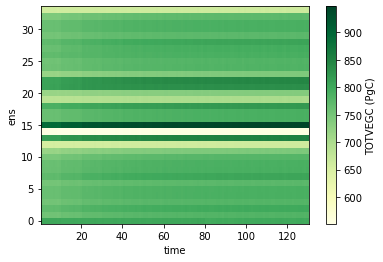

In [165]:
tvc = (1e-9*(la*ds.TOTVEGC).sum(dim='gridcell')).compute()
tvc.plot(cbar_kwargs={'label':'TOTVEGC (PgC)'},cmap='YlGn');

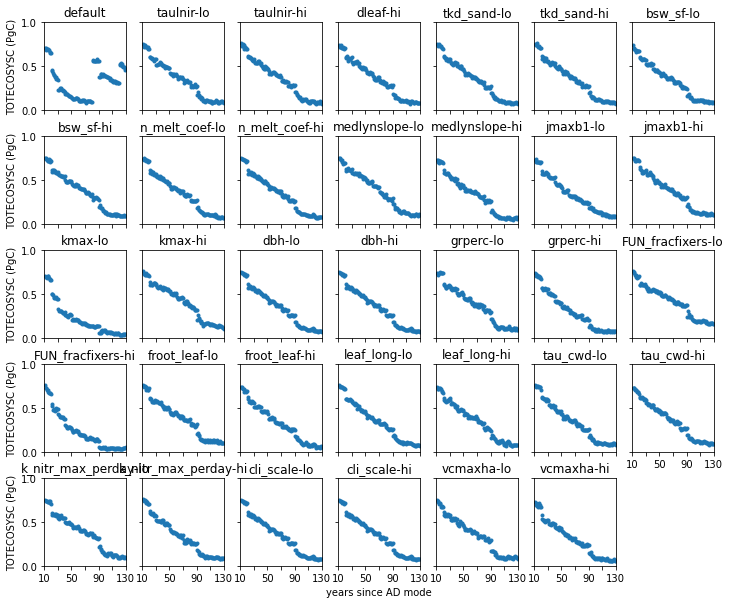

In [105]:
plt.figure(figsize=[12,10])
for i in range(nens):
    plt.subplot(5,7,i+1)
    plt.plot(11+np.arange(120),diseq[i,:],'.')
    plt.ylim([0,1])
    plt.xlim([10,130])
    plt.title(p2[i])
    
    if i%7==0:
        plt.yticks(np.arange(3)/2)
        plt.ylabel('TOTECOSYSC (PgC)')
    else:
        plt.yticks(np.arange(3)/2,'')
        
    if i>26:
        plt.xticks(10+20*np.arange(7),[10,'',50,'',90,'',130])
    else:
        plt.xticks(10+20*np.arange(7),'')
    if i==31:
        plt.xlabel('years since AD mode')
plt.subplots_adjust(hspace=0.3)



In [166]:
ix1 = 111+np.arange(10)
ix2 = 121+np.arange(10)
tec1 = ds.TOTECOSYSC.sel(time=ix1).mean(dim='time')
tec2 = ds.TOTECOSYSC.sel(time=ix2).mean(dim='time')
dtec = tec2-tec1
lasum = la.sum()
la_tiled = np.tile(la,[34,1])


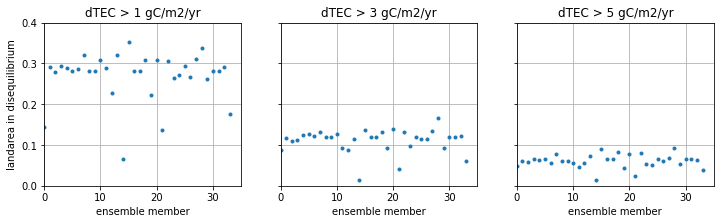

In [167]:
i=0
plt.figure(figsize=[12,3])
for thresh in 1+2*np.arange(3):
    i +=1
    ix_dtec = abs(dtec>10*thresh)
    tec_diseq = (ix_dtec*la_tiled).sum(dim='gridcell')/lasum
    plt.subplot(1,3,i)
    plt.plot(tec_diseq,'.')
    plt.xlabel('ensemble member')

    plt.title('dTEC > '+str(thresh)+' gC/m2/yr');
    plt.ylim([0,0.4]);
    plt.xlim([0,35])
    if i==1:
        plt.ylabel('landarea in disequilibrium')
        plt.yticks(np.arange(5)/10)
    else:
        plt.yticks(np.arange(5)/10,'')
    plt.grid()